# Static Toy Experiments

In [1]:
import torch

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("/trinity/home/a.kolesov/EFM/")
from src.data import MultiDimStackedGauss, MultiDimStackedMixtureGauss, SwissRollSampler
from src.utils import Config, get_mesh
from src.efm_field import EFMGroundTruth
from src.ifm_field import IFMGroundTruth
from src.ode import BaseODESolver, DippoleEFMODESolver

## 1. 3-dimensional example: Gaussian-to-Mixture

In [2]:
config = Config()

##### common #####
config.device = 'cuda' 
config.DIM = 3
config.L = 6.
config.NUM_SAMPLES = 1_000
config.NUM_MESH =7
config.DICT_MESH = {"z":[-5,5.], "x":[1e-5,8.], "y": [-8,8]}
##### common ##### 

##### p_data #####
config.p = Config()
config.p.dim = config.DIM -1
config.p.mean = (0.,0.)
config.p.x_loc = 0.
config.p.std = 1.
config.p.cov = None
##### p_data #####

##### q_data #####
config.q =  Config()
config.q.dim = config.DIM -1
config.q.num_components = 2
config.q.mix_probs = (0.5,0.5)
config.q.means = ((-8.,0.),(8.,0.))
config.q.stds = (1.,1.)
config.q.cov = None
config.q.x_loc = config.L
##### q_data ##### 


##### EFM #####
config.efm = Config()

config.efm.training = Config()
config.efm.training.stability = True
config.efm.training.gamma = 1e-7
##### EFM #####

##### IFM #####
config.ifm = Config()
config.ifm.name = "3d_mixture"
config.ifm.field_type = "Shifted"
config.ifm.field_form = 'exponential'
config.ifm.plan_type = 'Independent'
config.ifm.SCALE = 1.
config.ifm.K = 10.
config.ifm.D = math.pi/(2*config.ifm.K)
##### IFM #####


##### ode #####
config.ode = Config()
config.ode.step = 1.
config.ode.gamma = 0.
config.ode.behind_step = 1.5
config.ode.behind_num_steps = 350
##### ode #####

In [3]:
##### distribtutions #####
p_dist = MultiDimStackedGauss(config)
q_dist = MultiDimStackedMixtureGauss(config)

p_samples = p_dist.sample(config.NUM_SAMPLES).to(config.device)
q_samples = q_dist.sample(config.NUM_SAMPLES).to(config.device)
##### distribtutions #####



ode = {}
field = {}
maps ,traj = {},{}


##### EFM #####
mesh = get_mesh(config).to(config.device)
field['efm'] = EFMGroundTruth(mesh.clone(), p_samples, q_samples, config)
 
ode['efm'] =  DippoleEFMODESolver(config)
init = p_dist.sample(config.NUM_SAMPLES).to(config.device)
init[:,0] =  0.05 # starting point problem,
maps['efm'], traj['efm'],_ = ode['efm'](EFMGroundTruth, init , p_samples.clone(), q_samples.clone())
##### EFM #####


##### IFM #####
mesh = get_mesh(config).to(config.device)
field['ifm'] = IFMGroundTruth(mesh.clone(), p_samples, q_samples, config)

ode['ifm'] =  BaseODESolver(config)
init = p_dist.sample(config.NUM_SAMPLES).to(config.device)
init[:,0] =  0.15 # starting point problem, D dependecy;
maps['ifm'], traj['ifm'] = ode['ifm'](IFMGroundTruth, init , p_samples.clone(), q_samples.clone())
##### IFM ####

traj['efm'] = torch.stack(traj['efm'] ,dim=0)
traj['ifm'] = torch.stack(traj['ifm'],dim=0)

100%|██████████| 350/350 [00:00<00:00, 1009.31it/s]


/trinity/home/a.kolesov/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/trinity/home/a.kolesov/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_l

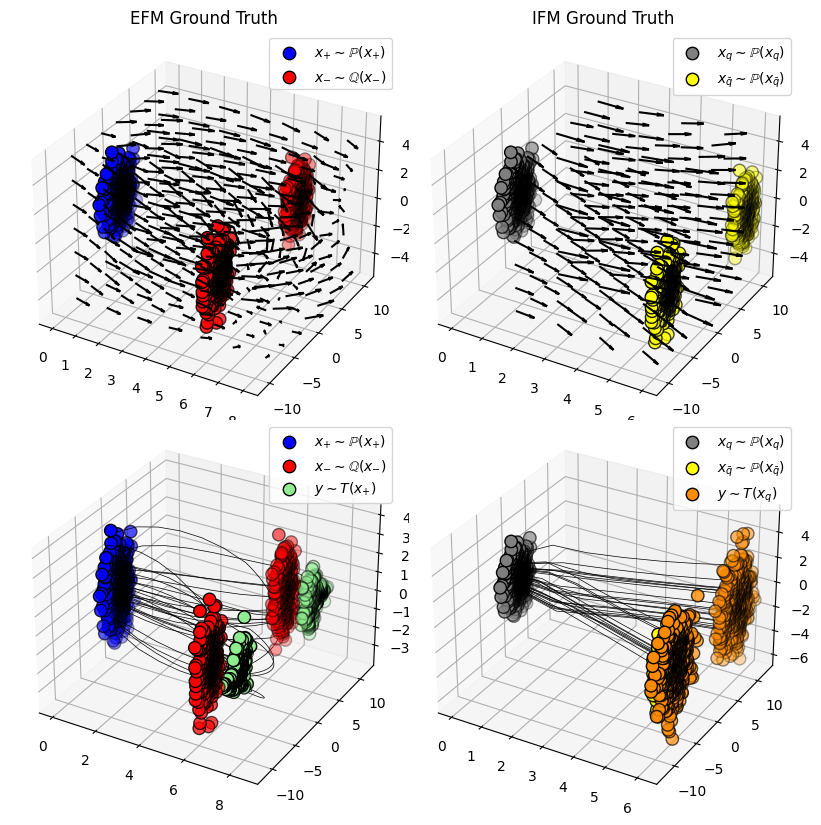

In [4]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
 
 
    
ax = fig.add_subplot(2,2,1,  projection='3d' )
ax.scatter(p_samples[:,0].cpu(),p_samples[:,1].cpu(),p_samples[:,2].cpu(),
           color='blue',edgecolor='black',s=80,label=r'$x_{+}  \sim \mathbb{P}(x_{+})$')
ax.scatter(q_samples[:,0].cpu(),q_samples[:,1].cpu(),q_samples[:,2].cpu(),
           color='red',edgecolor='black',s=80,label=r'$x_{-}  \sim \mathbb{Q}(x_{-})$')
ax.quiver(mesh[:, 0].cpu(), mesh[:, 1].cpu(), mesh[:,2].cpu(),
          field['efm'][:, 0].cpu(), field['efm'][:, 1].cpu(), field['efm'][:,2].cpu(),
          color='black',length=1, normalize=True)
ax.set_title(f"EFM Ground Truth")
ax.legend()


ax = fig.add_subplot(2,2,2,  projection='3d' )
ax.scatter(p_samples[:,0].cpu(),p_samples[:,1].cpu(),p_samples[:,2].cpu(),
           color='gray',edgecolor='black',s=80,label=r'$x_{q}  \sim \mathbb{P}(x_{q})$')
ax.scatter(q_samples[:,0].cpu(),q_samples[:,1].cpu(),q_samples[:,2].cpu(),
           color='yellow',edgecolor='black',s=80,label=r'$x_{\bar{q}}  \sim \mathbb{P}(x_{\bar{q}})$')
ax.quiver(mesh[:, 0].cpu(), mesh[:, 1].cpu(), mesh[:,2].cpu(),
          field['ifm'][:, 0].cpu(), field['ifm'][:, 1].cpu(), field['ifm'][:,2].cpu(),
          color='black',length=1, normalize=True)
ax.set_title(f"IFM Ground Truth")
ax.legend()


ax = fig.add_subplot(2,2,3,  projection='3d' )
ax.scatter(p_samples[:,0].cpu(),p_samples[:,1].cpu(),p_samples[:,2].cpu(),
           color='blue',edgecolor='black',s=80, label=r'$x_{+}  \sim \mathbb{P}(x_{+})$')
ax.scatter(q_samples[:,0].cpu(),q_samples[:,1].cpu(),q_samples[:,2].cpu(),
           color='red',edgecolor='black',s=80, label=r'$x_{-}  \sim \mathbb{Q}(x_{-})$')

traj['efm'][-1,:,0] = 7.3

ax.scatter(traj['efm'][-1][:,0].cpu(),traj['efm'][-1][:,1].cpu(),traj['efm'][-1][:,2].cpu(),
          color='lightgreen',edgecolor='black',zorder=20,label=r'$y \sim  T(x_{+})$',s=80)
for idx in range(200,230):
    ax.plot(traj['efm'][: ,idx,0].cpu(), 
        traj['efm'][:, idx,1].cpu(),
        traj['efm'][:, idx,2].cpu(),
        color='black',linewidth=0.5, zorder=3);
     
ax.legend()


ax = fig.add_subplot(2,2,4,  projection='3d' )
ax.scatter(p_samples[:,0].cpu(),p_samples[:,1].cpu(),p_samples[:,2].cpu(),
           color='gray',edgecolor='black',s=80,label=r'$x_{q}  \sim \mathbb{P}(x_{q})$')
ax.scatter(q_samples[:,0].cpu(),q_samples[:,1].cpu(),q_samples[:,2].cpu(),
           color='yellow',edgecolor='black',s=80,label=r'$x_{\bar{q}}  \sim \mathbb{P}(x_{\bar{q}})$')
ax.scatter(traj['ifm'][-1][:,0].cpu(),traj['ifm'][-1][:,1].cpu(),traj['ifm'][-1][:,2].cpu(),
          color='darkorange',edgecolor='black',s=80,label=r'$y \sim  T(x_{q})$')
for idx in range(200,230):
    ax.plot(traj['ifm'][: ,idx,0].cpu(), 
        traj['ifm'][:, idx,1].cpu(),
        traj['ifm'][:, idx,2].cpu(),
        color='black',linewidth=0.5, zorder=3);
     
ax.legend()


fig.tight_layout(pad=0.01)

## 2. 3-dimensional example: Gaussian-to-Swiss Roll

In [29]:
config = Config()

##### common #####
config.device = 'cuda' 
config.DIM = 3
config.L = 6.
config.NUM_SAMPLES = 2_000
config.NUM_MESH =7
config.DICT_MESH = {"z":[-5,5.], "x":[1e-5,8.], "y": [-8,8]}
##### common ##### 

##### p_data #####
config.p = Config()
config.p.dim = config.DIM -1
config.p.mean = (0.,0.)
config.p.x_loc = 0.
config.p.std = 1.
config.p.cov = None
##### p_data #####

##### q_data #####
config.q =  Config()
config.q.dim = config.DIM -1
config.q.x_loc = 6.
config.q.swiss_noise = None
##### q_data ##### 


##### EFM #####
config.efm = Config()

config.efm.training = Config()
config.efm.training.stability = True
config.efm.training.gamma = 1e-7
##### EFM #####

##### IFM #####
config.ifm = Config()
config.ifm.name = "3d_swiss"
config.ifm.field_type = "Shifted"
config.ifm.field_form = 'exponential'
config.ifm.plan_type = 'Independent'
config.ifm.SCALE = 1.
config.ifm.K = 1.
config.ifm.D = math.pi/(2*config.ifm.K)
##### IFM #####


##### ode #####
config.ode = Config()
config.ode.step = .25
config.ode.gamma = 0.
config.ode.behind_step = 1.5
config.ode.behind_num_steps = 350
##### ode #####

In [30]:
##### distribtutions #####
p_dist = MultiDimStackedGauss(config)
q_dist = SwissRollSampler(config)

p_samples = p_dist.sample(config.NUM_SAMPLES).to(config.device)
q_samples = q_dist.sample(config.NUM_SAMPLES).to(config.device)
##### distribtutions #####



ode = {}
field = {}
maps ,traj = {},{}


##### EFM #####
mesh = get_mesh(config).to(config.device)
field['efm'] = EFMGroundTruth(mesh.clone(), p_samples, q_samples, config)
 
ode['efm'] =  DippoleEFMODESolver(config)
init = p_dist.sample(config.NUM_SAMPLES).to(config.device)
init[:,0] =  0.05 # starting point problem,
maps['efm'], traj['efm'],_ = ode['efm'](EFMGroundTruth, init , p_samples.clone(), q_samples.clone())
##### EFM #####


##### IFM #####
mesh = get_mesh(config).to(config.device)
field['ifm'] = IFMGroundTruth(mesh.clone(), p_samples, q_samples, config)

ode['ifm'] =  BaseODESolver(config)
init = p_dist.sample(config.NUM_SAMPLES).to(config.device)
init[:,0] =  0.1 # starting point problem, D dependecy;
maps['ifm'], traj['ifm'] = ode['ifm'](IFMGroundTruth, init , p_samples.clone(), q_samples.clone())
##### IFM ####

traj['efm'] = torch.stack(traj['efm'] ,dim=0)
traj['ifm'] = torch.stack(traj['ifm'],dim=0)

100%|██████████| 350/350 [00:00<00:00, 790.68it/s]


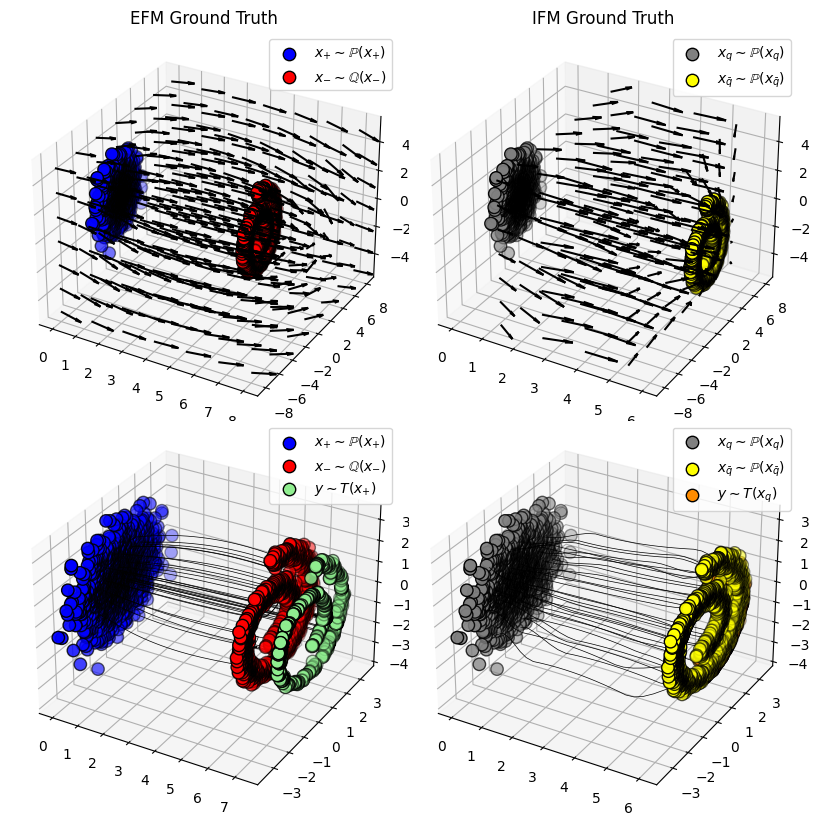

In [31]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
 
 
    
ax = fig.add_subplot(2,2,1,  projection='3d' )
ax.scatter(p_samples[:,0].cpu(),p_samples[:,1].cpu(),p_samples[:,2].cpu(),
           color='blue',edgecolor='black',s=80,label=r'$x_{+}  \sim \mathbb{P}(x_{+})$')
ax.scatter(q_samples[:,0].cpu(),q_samples[:,1].cpu(),q_samples[:,2].cpu(),
           color='red',edgecolor='black',s=80,label=r'$x_{-}  \sim \mathbb{Q}(x_{-})$')
ax.quiver(mesh[:, 0].cpu(), mesh[:, 1].cpu(), mesh[:,2].cpu(),
          field['efm'][:, 0].cpu(), field['efm'][:, 1].cpu(), field['efm'][:,2].cpu(),
          color='black',length=1, normalize=True)
ax.set_title(f"EFM Ground Truth")
ax.legend()


ax = fig.add_subplot(2,2,2,  projection='3d' )
ax.scatter(p_samples[:,0].cpu(),p_samples[:,1].cpu(),p_samples[:,2].cpu(),
           color='gray',edgecolor='black',s=80,label=r'$x_{q}  \sim \mathbb{P}(x_{q})$')
ax.scatter(q_samples[:,0].cpu(),q_samples[:,1].cpu(),q_samples[:,2].cpu(),
           color='yellow',edgecolor='black',s=80,label=r'$x_{\bar{q}}  \sim \mathbb{P}(x_{\bar{q}})$')
ax.quiver(mesh[:, 0].cpu(), mesh[:, 1].cpu(), mesh[:,2].cpu(),
          field['ifm'][:, 0].cpu(), field['ifm'][:, 1].cpu(), field['ifm'][:,2].cpu(),
          color='black',length=1, normalize=True)
ax.set_title(f"IFM Ground Truth")
ax.legend()


ax = fig.add_subplot(2,2,3,  projection='3d' )
ax.scatter(p_samples[:,0].cpu(),p_samples[:,1].cpu(),p_samples[:,2].cpu(),
           color='blue',edgecolor='black',s=80, label=r'$x_{+}  \sim \mathbb{P}(x_{+})$')
ax.scatter(q_samples[:,0].cpu(),q_samples[:,1].cpu(),q_samples[:,2].cpu(),
           color='red',edgecolor='black',s=80, label=r'$x_{-}  \sim \mathbb{Q}(x_{-})$')

traj['efm'][-1,:,0] = 7.3

ax.scatter(traj['efm'][-1][:,0].cpu(),traj['efm'][-1][:,1].cpu(),traj['efm'][-1][:,2].cpu(),
          color='lightgreen',edgecolor='black',zorder=20,label=r'$y \sim  T(x_{+})$',s=80)
for idx in range(200,230):
    ax.plot(traj['efm'][: ,idx,0].cpu(), 
        traj['efm'][:, idx,1].cpu(),
        traj['efm'][:, idx,2].cpu(),
        color='black',linewidth=0.5, zorder=3);
     
ax.legend()


ax = fig.add_subplot(2,2,4,  projection='3d' )
ax.scatter(p_samples[:,0].cpu(),p_samples[:,1].cpu(),p_samples[:,2].cpu(),
           color='gray',edgecolor='black',s=80,label=r'$x_{q}  \sim \mathbb{P}(x_{q})$')
ax.scatter(q_samples[:,0].cpu(),q_samples[:,1].cpu(),q_samples[:,2].cpu(),
           color='yellow',edgecolor='black',s=80,label=r'$x_{\bar{q}}  \sim \mathbb{P}(x_{\bar{q}})$')
ax.scatter(traj['ifm'][-1][:,0].cpu(),traj['ifm'][-1][:,1].cpu(),traj['ifm'][-1][:,2].cpu(),
          color='darkorange',edgecolor='black',s=80,label=r'$y \sim  T(x_{q})$')
for idx in range(200,230):
    ax.plot(traj['ifm'][: ,idx,0].cpu(), 
        traj['ifm'][:, idx,1].cpu(),
        traj['ifm'][:, idx,2].cpu(),
        color='black',linewidth=0.5, zorder=3);
     
ax.legend()


fig.tight_layout(pad=0.01)